# 1. 데이터 불러오기

### 가. 라이브러리 Import

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from dateutil.parser import parse
from tqdm import tqdm

import lightgbm as lgb
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 10)

sns.set(font="Hancom Gothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

: 

### 나. 데이터 프레임 변수로 저장
* csv : pd.read_csv("파일이름. csv")
* txt : pd.read_csv("파일이름. csv", sep="구분자")
* xlsx : pd.read_excel('파일이름.xlsx')
* pickle : pd.read_pickle("파일이름.pkl") <br>
 [참고] pickle은 파이썬의 모든 객체를 파일로 저장할 수 있는 방법으로 DataFrame,List,Dict 등 모든 객체 저장 가능(특히 sklearn라이브러리를 통해 모델을 학습시키고, 저장할 때 많이 사용)

In [ ]:
train = pd.read_csv("./Data/train.csv").drop( axis=1, columns='SAMPLE_ID')
test = pd.read_csv("./Data/test.csv").drop( axis=1, columns='SAMPLE_ID')
# train.drop('index', axis=1, inplace=True)
train # 데이터 프레임 확인하기

: 

In [ ]:
col_dic = {'ARI_CO':'도착국가',
            'ARI_PO':'도착 항구명',
            'SHIP_TYPE_CATEGORY':'5대 선종으로 분류',
            'DIST':'정박지와 접안지 거리(km)',
            'ATA':'실제 정박 시각(H)',
            'ID':'선박식별 일련번호',
            'BREADTH':'선박 폭(m)',
            'BUILT':'선박 연령',
            'DEADWEIGHT':'선박 재화중량톤수(t)',
            'DEPTH':'선박 깊이(m)',
            'DRAUGHT':'흘수 높이(m)',
            'GT':'용적톤수 값',
            'LENGTH':'선박 길이(m)',
            'SHIPMANAGER':'선박 소유주',
            'FLAG':'선박 국적',
            'U_WIND':'풍향 u벡터(m/s)',
            'V_WIND':'풍향 v벡터(m/s)',
            'AIR_TEMPERATURE':'기온(C)',
            'BN':'보퍼트 풍력 계급',
            'ATA_LT':'현지 정박 시각(H)',
            'DUBAI':'해당일의 두바이유 값($)',
            'BRENT':'해당일의 브렌트유 값($)',
            'WTI':'해당일의 WTI 값($)',
            'BDI_ADJ':'조정된 벌크운임지수',
            'PORT_SIZE':'접안지 폴리곤 영역의 크기',
            'CI_HOUR':'대기시간(h)'}

train = train.rename(columns=col_dic)
test = test.rename(columns=col_dic)
train

: 

# 2. 데이터 탐색(시각화)

##### 국가에 따라 대기시간이 긴 국가가 있나?
- ##### >>>> 남아프리카, 남미 이쪽은 확실히 대기시간이 길가
- ##### >>>> 비교적 아시아권이 대기시간이 짧다
- ##### >>>> 일 처리 방식, 문화에 따라 다를 수도 있겠음

In [ ]:
df = train.copy()

# 막대 그래프로 국가별 대기시간 비교
df_nation = df.groupby('도착국가').mean()

# 인덱스 리스트로
label = df_nation.index
plt.figure(figsize=(8,4))

# 인덱스를 X, 평균 가격을 Y로 하는 막대 그래프 
plt.bar(label, df_nation['대기시간(h)'])
plt.xlabel('국가')
plt.ylabel('대기시간')
plt.show()

: 

##### 도착 시간에 따른 대기시간 차이가 있나?
- ##### >>>> 현지 기준으로 18시 부터 6시 전에 도착하면 대기시간이 는다는 것을 알 수 있다. 주 근무시간 때문에 그런듯 하다.
- ##### >>>> 몰리는 도착시간이 있나?

In [ ]:
df_temp = df.copy()

df_temp['실제 정박 시각(H)'] = pd.to_datetime(df_temp['실제 정박 시각(H)'])

df_temp['정박 시간(H)'] = df_temp['실제 정박 시각(H)'].apply(lambda x : int(x.strftime('%H')))

df_temp_1 = df_temp.groupby('정박 시간(H)').mean()

# 그래프
plt.figure(figsize=(10,5))

plt.plot(df_temp_1['대기시간(h)'])
plt.xlabel('실제 도착 시간')
plt.ylabel('대기 시간')
plt.title('도착시간에 따른 대기시간의 변화가 있을까?')
plt.show()

: 

In [ ]:
df_temp_2 = df_temp.groupby('현지 정박 시각(H)').mean()

# 그래프
plt.figure(figsize=(10,5))

plt.plot(df_temp_2['대기시간(h)'])
plt.xlabel('현지 도착 시간')
plt.ylabel('대기 시간')
plt.title('도착시간(현지)에 따른 대기시간의 변화가 있을까?')
plt.show()

: 

In [ ]:
df_temp['정박 시간(H)'].value_counts().index.size
df_temp['정박 시간(H)'].value_counts().index

df_temp['대기시간(h)'].mean()

: 

##### 몰리는 도착시간이 있나?
- ##### >>>> uniform distribution 성격을 가짐

In [ ]:

df_temp_1 = df_temp['정박 시간(H)'].value_counts()

# 그래프
plt.figure(figsize=(8,8))

plt.pie(df_temp_1, labels = df_temp_1.index, autopct='%.1f%%')
plt.title('집중되는 도착시간이 있을까?(정박 시간대별 비율)')
plt.show()

: 

In [ ]:
ax = sns.catplot(data=df_temp, x='대기시간(h)', y='5대 선종으로 분류', )
ax.fig.set_size_inches(20,4)
plt.show()

: 

In [ ]:
train['대기시간(h)'].describe()


: 

# 3. 데이터 전처리

In [ ]:
train.describe(include='all')

: 

In [ ]:
train.info()

: 

In [ ]:
train.head()

: 

### 가. 결측치 확인
- target에 결측지 없음
- 풍향 결측치 : 153486(41%)
- 기온 결측치 : 154365(42%)
- 보퍼트 풍력 계급 : 153486(41%)
- 선박 폭(m) : 1
- 선박 깊이(m) : 1
- 흘수 높이(m) : 1
- 선박 길이(m) : 1

In [ ]:
train[train.isna().any(axis=1)].head() #154366 행


: 

In [ ]:
def isNullSum(train):
    nullSum = train[train.isna().any(axis=1)].isnull().sum()
    result = nullSum[nullSum != 0]
    return result

print(isNullSum(train), '\n')
print(isNullSum(test))

: 

In [ ]:
(100*154365)/train.shape[0]

: 

##### 결측치 처리(fillna)

- 결측치를 채울 수 있지만, 1개의 결측치가 1행에 몰려있어 삭제하는 것이 더 효율적이다.
- 1개의 행을 삭제한다고 해서 30만개의 데이터에 영향을 주지 않기 때문이다.

In [ ]:
train[train['선박 폭(m)'].isna()] #일련번호 A457875
train[train['용적톤수 값'] == 500]['선박 폭(m)'].value_counts() # '용적톤수 값'과 상관관계가 높으므로 10으로 대체
train['선박 폭(m)'] = train['선박 폭(m)'].fillna(10.0)

print(isNullSum(train))
print()
print(isNullSum(test))

: 

##### 결측치 처리(drop)

In [ ]:
# 삭제
train.dropna(subset = ['선박 깊이(m)'], inplace=True)

# 확인
print(isNullSum(train))

: 

##### 결측치가 없을 경우 풍향벡터와 기온, 보퍼트 features 와 target 상관관계 보기
    - 0.05 이하로 상관관계가 없음

In [ ]:
train_corr = train.dropna(axis=0).corr()

sns.heatmap(train_corr, annot = True, annot_kws = {"size" : 7})

: 

##### 결측치 평균값으로 채우기

In [ ]:
# 시각 -> datetime으로 타입 변경 해서 정렬한 후 보기


# # train_datetime = train[train.isna().any(axis=1)].sort_values(by=['실제 정박 시각(H)'], ascending=True).reset_index()
# train_datetime = train.sort_values(by=['실제 정박 시각(H)'], ascending=True).reset_index()
# train_datetime.describe()

: 

In [ ]:
for df in [train, test]:
        dict = {'풍향 u벡터(m/s)':df['풍향 u벡터(m/s)'].mean(), 
                '풍향 v벡터(m/s)': df['풍향 v벡터(m/s)'].mean(),
                '기온(C)':df['기온(C)'].mean(),
                '보퍼트 풍력 계급':df['보퍼트 풍력 계급'].mean()}

        # 평균 값으로 채우기
        df.fillna(value=dict, inplace=True)

: 

In [ ]:
# 결측치 없는 것 확인
print(isNullSum(train))
print(isNullSum(test))

: 

### 나. 이상치 처리
- 이산형 : 선박의 폭(6), 선박의 깊이(4), 흘수 높이(3), 정박시각(24), 접안지폴리곤 영역 크기  
  
- 선박의 연령 : 대부분 60년 이하, 그 이후 값은 삭제해도 무방할 듯  
- 해당일의 WTI값 : 음수인 값은 삭제하거나 전,후일의 값으로 대체
- 해당일 두바이유/ 브렌트유/ WTI 는 유가에 관련된 변수로 서로 상관관계가 높다
- 위 3개의 변수들에 영향을 받틑 벌크운임지수 또한 상관관계를 갖는다.
- 선박의 길기가 길수록 재화중량톤수, 용적 톤수가 높아진다. 
- 재화중량톤수와 용적톤수는 상관관계를 갖는다.

##### 시각적으로 확인

In [82]:
sns.pairplot(train)
plt.show()

##### IQR(Inter Quartile Range)로 확인하기

- IQR 기준 이상치 확인하는 합수

In [83]:
def find_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = 1.5 * (Q3 - Q1)
    
    outlier = dataframe[( (dataframe[column] > (Q3 + IQR)) | (dataframe[column] < (Q1 - IQR)) )]
    
    return len(outlier)

- IQR 이상치 대체 함수 만들기

In [84]:
def replace_outliers(train, column):
    Q1 = train[column].quantile(0.25)
    Q3 = train[column].quantile(0.75)
    IQR = 1.5 * (Q3 - Q1)
    
    Min = Q1 - IQR
    Max = Q3 + IQR
    
    train.loc[(train[column] > Max) , column] = Max 
    train.loc[(train[column] < Min) , column] = Min 
    
    return train

In [85]:
# 숫자형 데이터 컬럼만 가져오기
cols = train.select_dtypes(include="number").columns
cols

Index(['정박지와 접안지 거리(km)', '선박 폭(m)', '선박 연령', '선박 재화중량톤수(t)', '선박 깊이(m)',
       '흘수 높이(m)', '용적톤수 값', '선박 길이(m)', '풍향 u벡터(m/s)', '풍향 v벡터(m/s)', '기온(C)',
       '보퍼트 풍력 계급', '현지 정박 시각(H)', '해당일의 두바이유 값($)', '해당일의 브렌트유 값($)',
       '해당일의 WTI 값($)', '조정된 벌크운임지수', '접안지 폴리곤 영역의 크기', '대기시간(h)'],
      dtype='object')

In [86]:
outliersCols = []
for col in cols:
    result = find_outliers(train, col)
    if result != 0:
        outliersCols.append(col)
        print(col, "이상치 개수 :", result)
        print('------------------------------------------------------')
    
print(outliersCols)

정박지와 접안지 거리(km) 이상치 개수 : 31649
------------------------------------------------------
선박 연령 이상치 개수 : 9233
------------------------------------------------------
선박 재화중량톤수(t) 이상치 개수 : 22945
------------------------------------------------------
흘수 높이(m) 이상치 개수 : 82090
------------------------------------------------------
용적톤수 값 이상치 개수 : 17152
------------------------------------------------------
풍향 u벡터(m/s) 이상치 개수 : 130046
------------------------------------------------------
풍향 v벡터(m/s) 이상치 개수 : 131840
------------------------------------------------------
기온(C) 이상치 개수 : 66516
------------------------------------------------------
보퍼트 풍력 계급 이상치 개수 : 99642
------------------------------------------------------
해당일의 두바이유 값($)

 이상치 개수 : 1995
------------------------------------------------------
해당일의 브렌트유 값($) 이상치 개수 : 3303
------------------------------------------------------
해당일의 WTI 값($) 이상치 개수 : 7434
------------------------------------------------------
조정된 벌크운임지수 이상치 개수 : 13266
------------------------------------------------------
대기시간(h) 이상치 개수 : 45786
------------------------------------------------------
['정박지와 접안지 거리(km)', '선박 연령', '선박 재화중량톤수(t)', '흘수 높이(m)', '용적톤수 값', '풍향 u벡터(m/s)', '풍향 v벡터(m/s)', '기온(C)', '보퍼트 풍력 계급', '해당일의 두바이유 값($)', '해당일의 브렌트유 값($)', '해당일의 WTI 값($)', '조정된 벌크운임지수', '대기시간(h)']


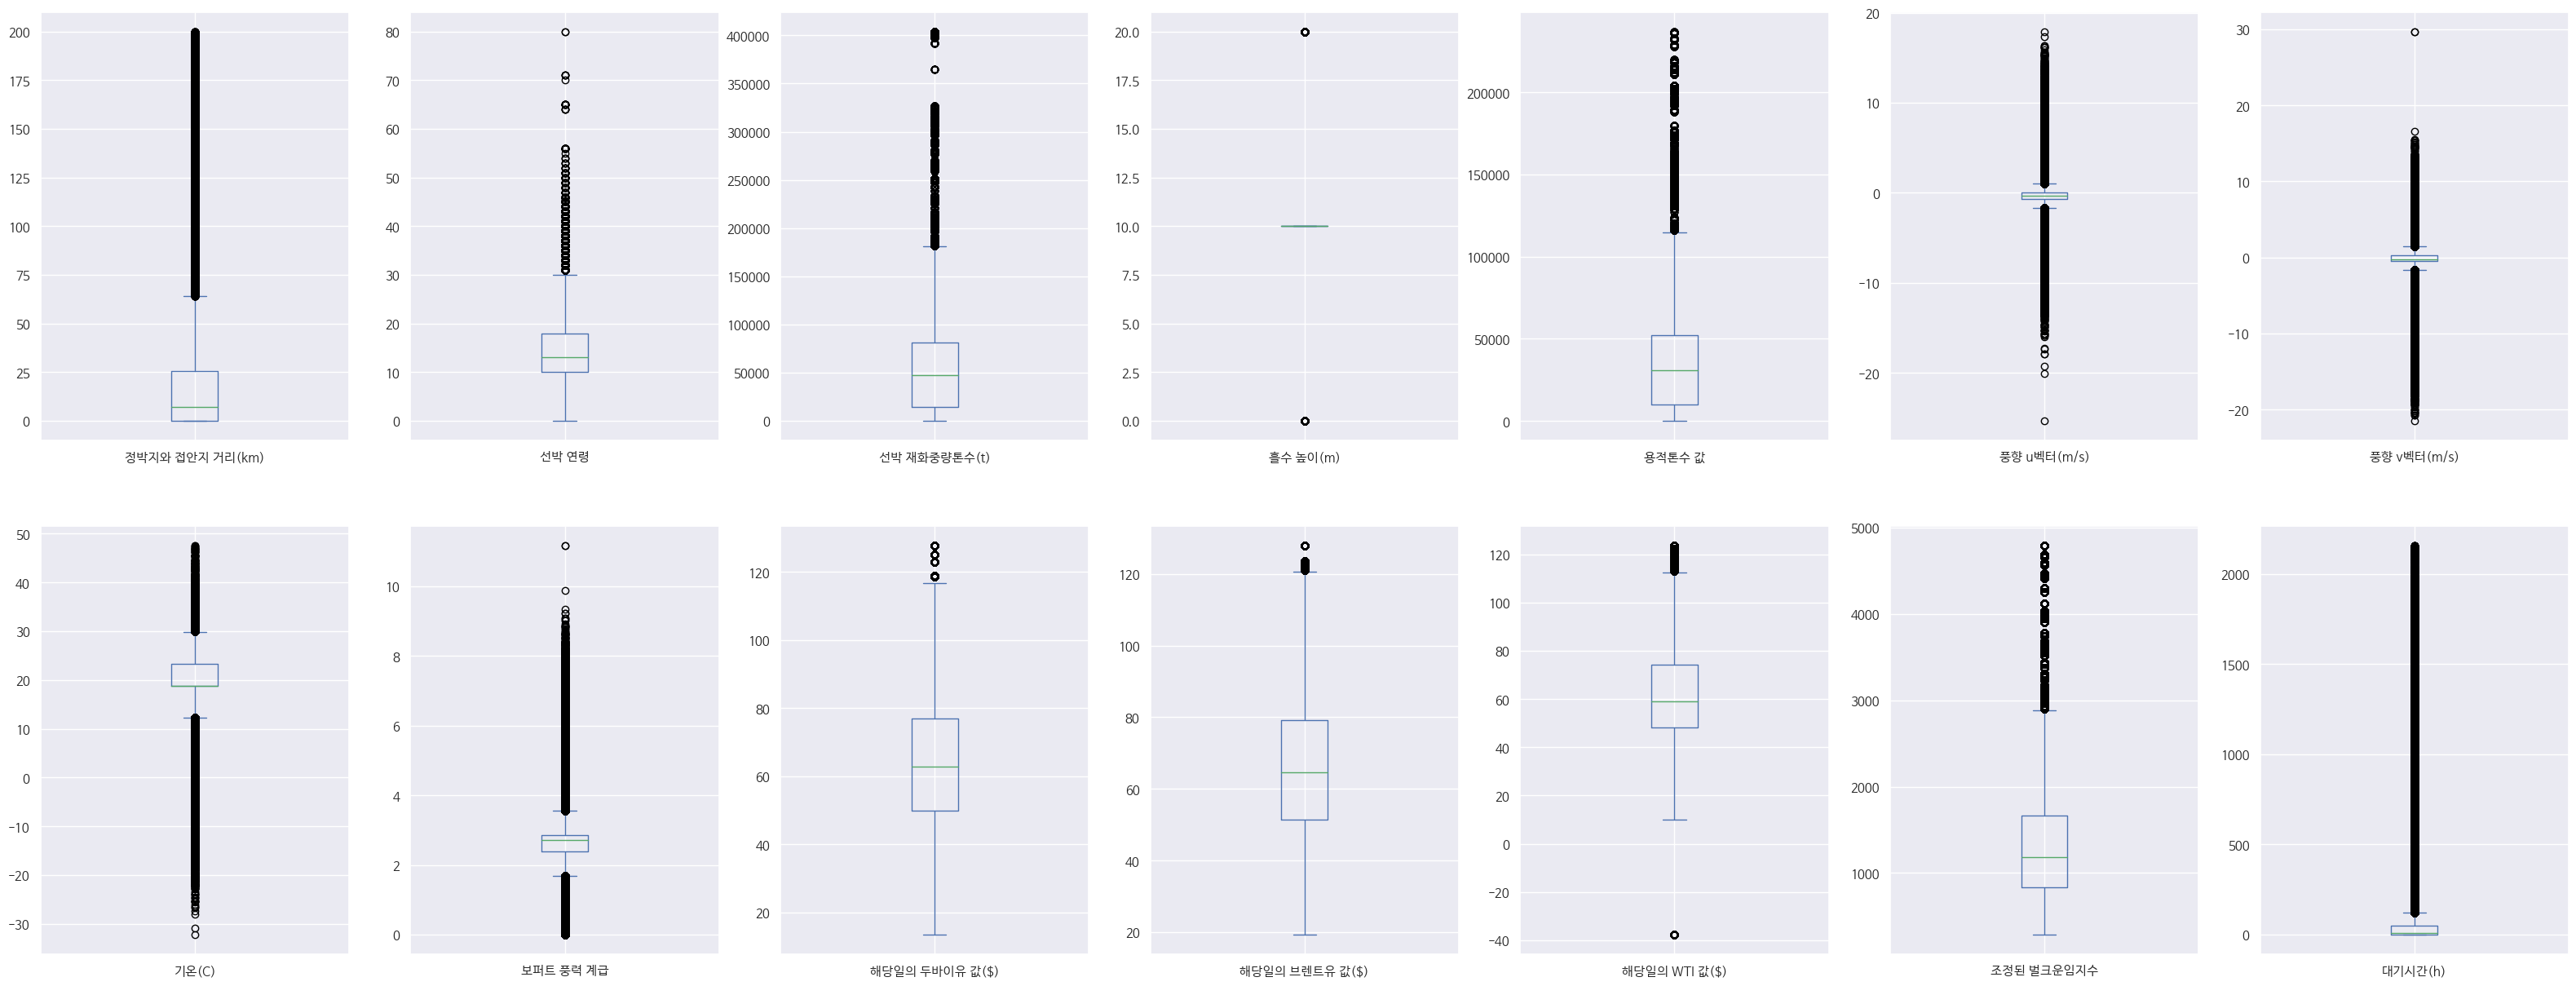

In [87]:
train[outliersCols].plot(kind='box', subplots=True, layout=(2, 7), figsize=(40, 15))
plt.show()

# 이상치가 아닌 것 : '흘수 높이(m)'
# wti에 있는 음수 값 제거하기

##### WTI값이 음수인 행 삭제

In [88]:
train = train[train['해당일의 WTI 값($)'] >= 0]
test = test[test['해당일의 WTI 값($)'] >= 0]

Text(0, 0.5, '해당일의 WTI 값($)')

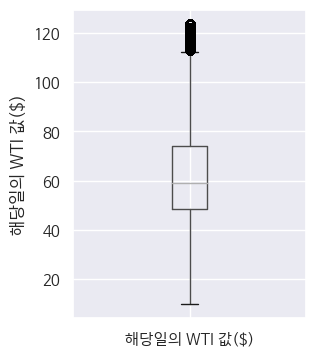

In [89]:
# 확인
plt.figure(figsize=(3,4))
train[['해당일의 WTI 값($)']].boxplot()
plt.ylabel('해당일의 WTI 값($)')

### 다.데이터 타입 변경(날짜 데이터는 DateTime으로)

In [90]:
train['실제 정박 시각(H)'] = pd.to_datetime(train['실제 정박 시각(H)'], format='%Y-%m-%d %H:%M')
test['실제 정박 시각(H)'] = pd.to_datetime(test['실제 정박 시각(H)'], format='%Y-%m-%d %H:%M')

train['실제 정박 시각(H)'].head()

0   2020-10-15 04:03:00
1   2019-09-17 02:55:00
2   2019-02-23 06:43:00
3   2020-09-18 22:06:00
4   2022-08-13 12:57:00
Name: 실제 정박 시각(H), dtype: datetime64[ns]

In [91]:
# train['실제 정박 시간'] = train['실제 정박 시각(H)'].apply(lambda x : x.strftime('%H:%M'))
# train['실제 정박 날짜'] = train['실제 정박 시각(H)'].apply(lambda x : x.strftime('%Y-%m-%d'))
# train = train.drop(axis=1, columns='실제 정박 시각(H)')
# train.head()

### 라. 파생변수 생성
#### - datetime을 여러 파생 변수로 변환

In [92]:
# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['실제 정박 시각(H)'].dt.year
    df['month'] = df['실제 정박 시각(H)'].dt.month
    df['day'] = df['실제 정박 시각(H)'].dt.day
    df['hour'] = df['실제 정박 시각(H)'].dt.hour
    df['minute'] = df['실제 정박 시각(H)'].dt.minute
    df['weekday'] = df['실제 정박 시각(H)'].dt.weekday

In [93]:
train.head(3)
test.head(3)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),해당일의 두바이유 값($),해당일의 브렌트유 값($),해당일의 WTI 값($),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,year,month,day,hour,minute,weekday
0,JP,HYG5,Tanker,9.508139,2022-08-27 08:29:00,R721438,20.0,9,5510,10.0,10.0,3720,100.0,VYRY76,Japan,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256,2022,8,27,8,29,5
1,SG,GIW5,Container,24.186684,2022-03-27 20:57:00,G185231,40.0,14,109000,20.0,10.0,94400,330.0,NLTW61,Portugal (Mar),-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615,2022,3,27,20,57,6
2,TW,EKP8,Cargo,0.000000,2023-01-18 02:06:00,P862781,20.0,14,13700,10.0,10.0,8930,140.0,UVJW25,"China, People's Republic Of",-6.25,-12.57,16.1,6.557436,10,83.70,84.98,79.48,682.595117,0.000427,2023,1,18,2,6,2


### 마. 데이터 탐색(다시)
##### - "연도에 따른 대기시간 변화가 있을까?"
- ##### >>>> 2014, 2023년은 데이터 수가 적기 때문에 제외
- ##### >>>> 2015~2022년가지 대기시간이 점점 증가하는 추세를 보이고 있다.
- ##### >>>> 코로나, 인터넷 발달로 세계에서 물류량이 늘어난 것으로 보인다.

In [94]:
train['year'] = train['year'].astype('O')

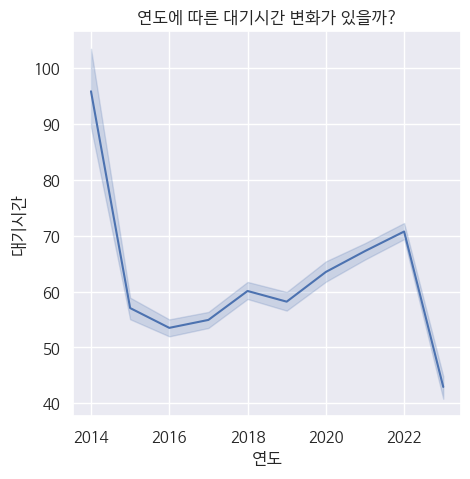

In [95]:
temp = train[['year', '대기시간(h)']]
temp.groupby('year').mean()

temp['대기시간(h)'] = round(temp['대기시간(h)'],2)
temp

plt.figure(figsize=(5,5))
# plt.scatter(x=temp['year'], y=temp['대기시간(h)'])
# sns.lineplot(data=temp, x="year", y='대기시간(h)', hue="month")
sns.lineplot(data=temp, x="year", y='대기시간(h)')
plt.xlabel("연도")
plt.ylabel("대기시간")
plt.title("연도에 따른 대기시간 변화가 있을까?")
plt.show()

In [96]:
train['month'].unique()

array([10,  9,  2,  8,  1,  6, 12,  3,  7, 11,  4,  5], dtype=int64)

##### - "연도/월별 대기시간 변화가 있을까?"

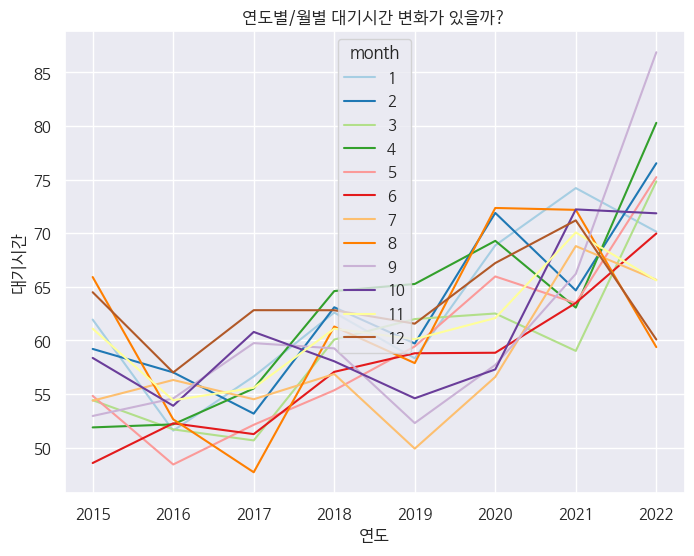

In [97]:
temp = train[['month', 'year', '대기시간(h)']]
temp['대기시간(h)'] = round(temp['대기시간(h)'],2)

# month가 모두 있지 않은 연도는 제외하고 자세히 보기
temp = temp[(temp.year != 2014)&(temp.year != 2023)]

plt.figure(figsize=(8,6))
sns.lineplot(data=temp, x="year", y='대기시간(h)', hue="month", 
             palette='Paired', legend= "full" , ci=None)
plt.xlabel("연도")
plt.ylabel("대기시간")
plt.title("연도별/월별 대기시간 변화가 있을까?")
plt.show()

### ( 데이터 중간 저장 )

In [98]:
# 데이터 중간 저장

train.to_csv( "./Data/train(신규변수 및 인코딩 전).csv", index=False)

### 바. 신규/파생 변수 생성(나중에 해보기)
#### - '조정된 벌크운임지수'와 '두바이/브렌트/WTI 값' 3개간 연관성이 높다고 판단 -> Linear Regression으로 관계 확인하기

In [99]:
# train['국가-항구명'] = train['도착국가'] + "-" + train['도착 항구명']
# train.drop(inplace=True, axis=1, columns=['도착국가', '도착 항구명'])

In [100]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [101]:
Oil_BDI = train.loc[: , '해당일의 두바이유 값($)' : '조정된 벌크운임지수']

x = Oil_BDI.drop('조정된 벌크운임지수', axis=1)
y = Oil_BDI[['조정된 벌크운임지수']]

x.head(3)

,해당일의 두바이유 값($),해당일의 브렌트유 값($),해당일의 WTI 값($)
0,42.01,43.16,40.96
1,67.53,64.55,59.34
2,65.30,66.39,56.94


점수  0.20545161994989591
해당일의 두바이유 값($) 회귀계수 : [15.99976989] [301.25252173]


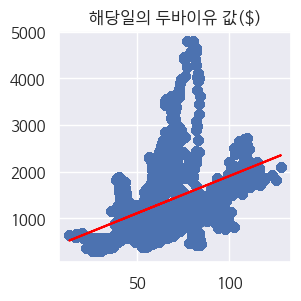

점수  0.19843604634060763
해당일의 브렌트유 값($) 회귀계수 : [15.52672077] [299.15282643]


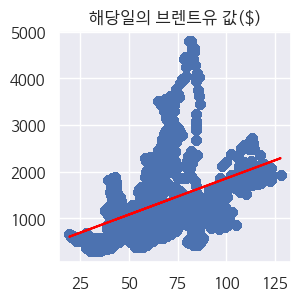

점수  0.22186981980901865
해당일의 WTI 값($) 회귀계수 : [16.99032426] [274.68900906]


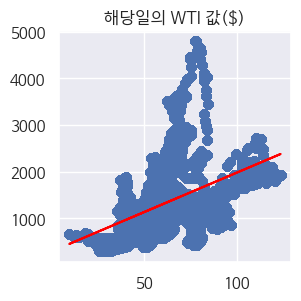

In [102]:
result = {'x_Dubai':[], 'x_Brent':[], 'x_WTI':[]}
keys_name = list(result.keys())


# 각각의 변수들에 대한 단순선형회귀 적용
for n in range(3):
    lr = LinearRegression()
    
    x_temp = x.iloc[:, n].values.reshape(-1,1)
    
    X_train, X_test, y_train, y_test = train_test_split(x_temp, y)
    
    lr.fit(X_train, y_train)
    print('점수 ', lr.score(X_test,y_test))
    
    result[keys_name[n]].append(lr.coef_[0][0])
    result[keys_name[n]].append(lr.intercept_[0])
    result[keys_name[n]].append(lr.score(X_test,y_test))
    print(x.columns[n], '회귀계수 :', lr.coef_[0], lr.intercept_)
    
    line = lr.coef_[0]*x_temp + lr.intercept_
    plt.figure(figsize=(3,3))
    plt.scatter(x_temp, y)
    plt.plot(x_temp, line, color='red')
    plt.title(f'{x.iloc[:, n].name}')
    plt.show()

In [103]:
result 

{'x_Dubai': [15.999769891033422, 301.25252173088984, 0.20545161994989591],
 'x_Brent': [15.526720771528275, 299.1528264349038, 0.19843604634060763],
 'x_WTI': [16.990324258326915, 274.6890090556726, 0.22186981980901865]}

In [104]:
# 조화평균 함수 만들기
def find_harmonic_mean(list):
    r2_sum = 0
    for r2 in list:
        r2_sum += (1/r2)
    result = len(list)/r2_sum
    return result 

In [105]:
coefs = [re[0] for re in list(result.values())]
intercepts = [re[1] for re in list(result.values())]
r2s = [re[2] for re in list(result.values())]

print("coef : ", coefs, 
      "산술평균 : ", sum(coefs)/3, 
      "조화평균 : ", find_harmonic_mean(coefs))

print("intercept : ", intercepts, 
      "산술평균 : ",sum(intercepts)/3, 
      "조화평균 : ",find_harmonic_mean(intercepts))

print("r2 : ", r2s, 
      "산술평균 : ",sum(r2s)/3, 
      "조화평균 : ",find_harmonic_mean(r2s))


coef :  [15.999769891033422, 15.526720771528275, 16.990324258326915] 산술평균 :  16.172271640296206 조화평균 :  16.149607624498337
intercept :  [301.25252173088984, 299.1528264349038, 274.6890090556726] 산술평균 :  291.69811907382206 조화평균 :  291.18501750406335
r2 :  [0.20545161994989591, 0.19843604634060763, 0.22186981980901865] 산술평균 :  0.20858582869984074 조화평균 :  0.20813271042130044


In [106]:
# 모든 데이터로 다중선형회귀 사용했을 떄 결과 >> 비슷함

lr = LinearRegression()
    
X_train, X_test, y_train, y_test = train_test_split(x, y)
    
lr.fit(X_train, y_train)

print('점수 ', lr.score(X_test,y_test))

print('회귀계수 :', lr.coef_[0], lr.intercept_)

점수  0.3014646708572214
회귀계수 : [  59.44358178 -133.28189237   92.37523239] [615.95801165]


In [107]:
# results = sm.OLS(y, sm.add_constant(x_Dubai)).fit()
# results.summary()

In [108]:
# results = sm.OLS(y, sm.add_constant(x_Brent)).fit()
# results.summary()

In [109]:
# results = sm.OLS(y, sm.add_constant(x_WTI)).fit()
# results.summary()

In [110]:
r2s, sum(r2s)

([0.20545161994989591, 0.19843604634060763, 0.22186981980901865],
 0.6257574860995222)

In [111]:
r2s[0]/sum(r2s) + r2s[1]/sum(r2s) + r2s[2]/sum(r2s)

1.0

In [112]:
train['해당일 원유가격($)'] = train['해당일의 두바이유 값($)']*(r2s[0]/sum(r2s)) + train['해당일의 브렌트유 값($)']*(r2s[1]/sum(r2s)) + train['해당일의 WTI 값($)']*(r2s[2]/sum(r2s))

train = train.drop(['해당일의 두바이유 값($)', '해당일의 브렌트유 값($)', '해당일의 WTI 값($)'], axis=1)

train.head(3)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,대기시간(h),year,month,day,hour,minute,weekday,해당일 원유가격($)
0,CN,EKP8,Bulk,30.736578,2020-10-15 04:03:00,Z517571,30.0,28,73100,20.0,10.0,38600,220.0,CHMT36,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,1407.668330,0.001660,3.048333,2020,10,15,4,3,3,42.002390
1,CN,EUC8,Container,63.220425,2019-09-17 02:55:00,U467618,30.0,15,37900,20.0,10.0,28100,220.0,CUFV52,Singapore,-3.16,-6.72,24.5,4.289058,10,2089.046774,0.001614,17.138611,2019,9,17,2,55,1,63.681140
2,CN,NGG6,Container,90.427421,2019-02-23 06:43:00,V378315,50.0,7,115000,20.0,10.0,96400,300.0,ISIG88,Liberia,0.00,0.00,9.4,0.000000,14,603.193047,0.001743,98.827500,2019,2,23,6,43,5,62.681515


### 사. 필요 없는 컬럼 삭제하기
- 'SAMPLE_ID' : 인덱스 같은 것, 필요 없음
- '선박식별 일련번호' : 선박을 구분하기 위한 번호로 삭제해도 될 것으로 판단
    * 식별번호의 앞 글자가 영향을 주는지는 비교해봐야 할 듯
- '선박 소유주' : 대기시간과 무관
- '선박 국적' : 국가에 따른 협약 등이 작용하는지 모르겠음
- '선박 연령' : 선박이 오래될수록 대기시간이 짧을까?

In [113]:
train = train.drop(axis=1, columns=['실제 정박 시각(H)'])
test = test.drop(axis=1, columns=['실제 정박 시각(H)'])

In [114]:
train.head(3)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,대기시간(h),year,month,day,hour,minute,weekday,해당일 원유가격($)
0,CN,EKP8,Bulk,30.736578,Z517571,30.0,28,73100,20.0,10.0,38600,220.0,CHMT36,"China, People's Republic Of",0.14,3.77,15.9,2.730798,12,1407.668330,0.001660,3.048333,2020,10,15,4,3,3,42.002390
1,CN,EUC8,Container,63.220425,U467618,30.0,15,37900,20.0,10.0,28100,220.0,CUFV52,Singapore,-3.16,-6.72,24.5,4.289058,10,2089.046774,0.001614,17.138611,2019,9,17,2,55,1,63.681140
2,CN,NGG6,Container,90.427421,V378315,50.0,7,115000,20.0,10.0,96400,300.0,ISIG88,Liberia,0.00,0.00,9.4,0.000000,14,603.193047,0.001743,98.827500,2019,2,23,6,43,5,62.681515


In [115]:
test.head(3)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),해당일의 두바이유 값($),해당일의 브렌트유 값($),해당일의 WTI 값($),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,year,month,day,hour,minute,weekday
0,JP,HYG5,Tanker,9.508139,R721438,20.0,9,5510,10.0,10.0,3720,100.0,VYRY76,Japan,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256,2022,8,27,8,29,5
1,SG,GIW5,Container,24.186684,G185231,40.0,14,109000,20.0,10.0,94400,330.0,NLTW61,Portugal (Mar),-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615,2022,3,27,20,57,6
2,TW,EKP8,Cargo,0.000000,P862781,20.0,14,13700,10.0,10.0,8930,140.0,UVJW25,"China, People's Republic Of",-6.25,-12.57,16.1,6.557436,10,83.70,84.98,79.48,682.595117,0.000427,2023,1,18,2,6,2


### 아. Categorical 컬럼 인코딩

In [116]:
categorical_features = ['도착국가' , '도착 항구명', '5대 선종으로 분류', '선박식별 일련번호', '선박 소유주', '선박 국적']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


In [117]:
train.head(3)


,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,대기시간(h),year,month,day,hour,minute,weekday,해당일 원유가격($)
0,4,13,0,30.736578,24336,30.0,28,73100,20.0,10.0,38600,220.0,591,18,0.14,3.77,15.9,2.730798,12,1407.668330,0.001660,3.048333,2020,10,15,4,3,3,42.002390
1,4,14,2,63.220425,19551,30.0,15,37900,20.0,10.0,28100,220.0,723,100,-3.16,-6.72,24.5,4.289058,10,2089.046774,0.001614,17.138611,2019,9,17,2,55,1,63.681140
2,4,45,2,90.427421,20448,50.0,7,115000,20.0,10.0,96400,300.0,2198,65,0.00,0.00,9.4,0.000000,14,603.193047,0.001743,98.827500,2019,2,23,6,43,5,62.681515


In [118]:
test.head(3)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),해당일의 두바이유 값($),해당일의 브렌트유 값($),해당일의 WTI 값($),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,year,month,day,hour,minute,weekday
0,9,26,4,9.508139,16892,20.0,9,5510,10.0,10.0,3720,100.0,5546,58,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256,2022,8,27,8,29,5
1,18,22,3,24.186684,5748,40.0,14,109000,20.0,10.0,94400,330.0,3357,93,-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615,2022,3,27,20,57,6
2,20,14,2,0.000000,15243,20.0,14,13700,10.0,10.0,8930,140.0,5246,19,-6.25,-12.57,16.1,6.557436,10,83.70,84.98,79.48,682.595117,0.000427,2023,1,18,2,6,2


### ( 데이터 중간 저장 )

In [119]:
# 데이터 중간 저장

train.to_csv( "./Data/train(인코딩 후).csv", index=False)
test.to_csv( "./Data/test(인코딩 후).csv", index=False)

-----

In [ ]:
X_copy = X.copy()
X_copy = X_copy.iloc[:500, :]
X_copy = X_copy.astype('float32')

In [ ]:
X_centered = X_copy - X_copy.mean(axis=0)

# 모든 주성분 구하기
U,s,Vt = np.linalg.svd(X_centered)

# PC를 구성하는 3개의 단위벡터 추출
for n in range(3):
    globals()[f'PC_com{n}'] = Vt.T[:, n]

# # 확인
# for n in range(3):
#     print(globals()[f'PC_com{n}'])

s*s / (3-1)


array([1.5917970e+06, 3.0353625e+05, 1.6189312e+05, 3.9746434e+04,
       1.6368599e+04, 7.2959100e+02, 6.7408826e+02, 6.4715552e+02,
       5.9658276e+02, 5.5222784e+02, 3.8975494e+02, 1.9653186e+02,
       1.6858316e+02, 1.5995549e+02, 1.4865793e+02, 1.3182968e+02,
       1.1987950e+02, 8.3553246e+01, 7.4494507e+01, 7.3120445e+01,
       6.1777840e+01, 5.2831238e+01, 5.2575230e+01, 4.9007370e+01,
       3.8918602e+01, 3.6611938e+01, 2.3818571e+01, 2.1490780e+01,
       1.4800338e+01, 1.2914721e-02], dtype=float32)

In [ ]:
# 사이킷런 사용
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X2D = pca.fit_transform(X_copy)

print("설명된 분산의 비율 : ", pca.explained_variance_ratio_)

# 주성분을 구성하는 단위벡터 3개 확인
for n in range(3):
    # print(pca.components_.T[:, n])
    print(pca.components_.T[:, n])


설명된 분산의 비율 :  [0.9547124  0.03471511 0.00987538]
[-2.1636146e-05  3.3186512e-05 -5.1210181e-06 -1.3416591e-05
 -2.4811646e-03  1.3312497e-04 -2.8191907e-05  8.5132515e-01
  6.6302746e-05  5.3539490e-05  5.2462560e-01  9.3971868e-04
  2.0387759e-03  4.7556827e-05  8.8245918e-07  1.1253200e-06
  3.2462804e-06  2.0450027e-07  3.4785259e-07 -3.2089662e-05
 -3.2560889e-05 -3.4276261e-05 -1.5529924e-03 -1.1509748e-09
 -6.3849679e-06 -2.0026566e-06 -9.9381350e-06 -7.1497539e-06
 -9.9387362e-06 -8.6756074e-07]
[ 9.01673266e-05 -4.79595241e-04  4.06191757e-05 -1.17272175e-04
  4.49714810e-02  1.64416764e-04 -7.46044498e-06 -5.24002612e-01
  1.13006783e-04 -1.21146923e-05  8.50516737e-01  1.65775220e-03
  3.40734469e-03  3.70429552e-05 -2.14301622e-06 -5.76170760e-06
  1.58729090e-05  9.20465482e-06  9.92010337e-06  2.82354849e-05
  4.39171599e-05  4.98839254e-05  2.10877275e-03  2.32943567e-08
  2.51613596e-06 -4.29802128e-07  3.52682764e-05  2.10209619e-05
  2.21129199e-06 -6.90446450e-06]
[-8

### 라. [소개] 요인분석(FactorAnalyzer)
#### 다중공선성의 문제를 해결할 다른 방법은 무엇이 있을까? A: 변수를 변형시키거나 새로운 관측치를 이용
##### 요인분석이란 변수들 사이에서 잠재된 변수를 찾는 과정입니다. 이해를 위해 조금 거칠게 표현하면 드라마 선호도를 확인할 때 로멘스. 휴머니티, 범죄/스릴러, 정치, SF, 판타지 6가지로 조사한다면 내면에는 감성적(로맨스, 휴머니티), 이성적(범죄/스릴러, 정치), 창의적(SF, 판타지) 3가지 잠재적 요소의 영향을 확인하는 과정이라고 할 수 있습니다.
##### 요인분석을 통해 우리는 변수를 축소할 수 있고 잠재된 요소를 확인 할 수 있으나, 반드시 좋은 결과를 담보하는 것은 아니니 입체적으로 바라보고 적용해야 합니다.(일반적으로 크론바흐 계수 0.7이상에서 용인)

##### 1) 라이브러리 Import

In [113]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo

##### 2) Kaiser-Meyer-Olkin (KMO) 검정 : 요인 분석을위한 데이터의 적합성을 측정(0.6 미만의 KMO 값은 부적절한 것으로 간주)

In [114]:
# 요인분석은 수치형변수(int, float 등)으로만 이루어진 데이터에서 가능함으로 문자형 변수는 제거 필요

In [115]:
kmo_all,kmo_model=calculate_kmo(X_copy)
kmo_model # 0.642878086837649 : 0.6 이상으로 양호함

0.7853920765930849

##### 3) ScreePlot을 활용한 요인수 결정 : Elbow 기법
* 고유값(각각의 요인으로 설명할 수 있는 변수들의 분산 총합) 시각화

In [116]:
# 요인분석 오브젝트를 만들고 실행해보겠습니다.
fa = FactorAnalyzer()
fa.set_params(rotation=None)
fa.fit(X_copy)
# 고유값 확인 * 고유값(eigenvalue):각각의 요인으로 설명할 수 있는 변수들의 분산 총합
ev, v = fa.get_eigenvalues()
ev

array([5.83673778e+00, 3.53021788e+00, 2.08528630e+00, 1.42613328e+00,
       1.36446602e+00, 1.33249978e+00, 1.29067977e+00, 1.16008133e+00,
       1.05791359e+00, 1.00849151e+00, 9.79906324e-01, 9.60281796e-01,
       9.19178293e-01, 8.52582339e-01, 8.20684341e-01, 7.74948962e-01,
       7.41691370e-01, 7.27277072e-01, 6.24638036e-01, 5.49130016e-01,
       5.00056765e-01, 4.14107581e-01, 3.64666594e-01, 3.02339280e-01,
       1.62011768e-01, 1.08320129e-01, 5.76058964e-02, 3.39569755e-02,
       1.13752506e-02, 2.73480321e-03])

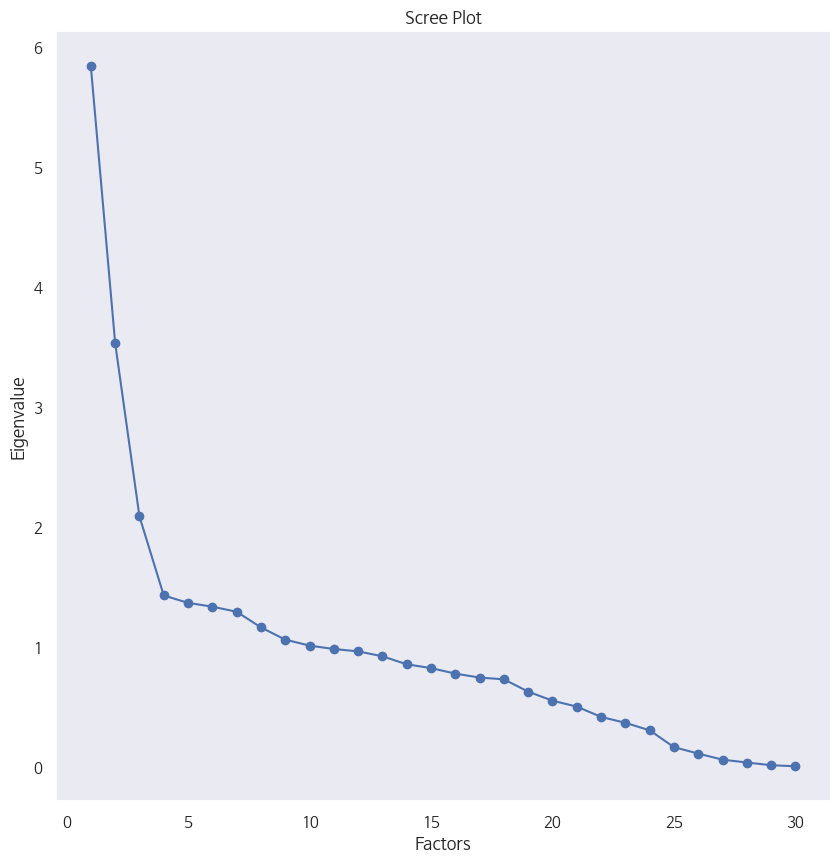

In [117]:
# Scree Plot을 그려서 Elbow 지점을 찾아봅시다.
plt.scatter(range(1,X_copy.shape[1]+1),ev)
plt.plot(range(1,X_copy.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

##### 4) 요인부하량 확인 및 시각화

In [275]:
# 요인분석 오브젝트를 만들고 실행해보겠습니다.
fa = FactorAnalyzer(method='principal', n_factors=9, rotation=None)
fa.fit(X_copy)
(pd.DataFrame(fa.loadings_) >= 0.4).sum() # 요인부하량 확인 : 0.4이상 유의미, 0.5이상 중요

0    6
1    6
2    3
3    2
4    2
5    2
6    2
7    1
8    2
dtype: int64

In [276]:
feature_names = list(X_copy.columns)
fa_result = pd.DataFrame(fa.loadings_, index=feature_names)

<Axes: >

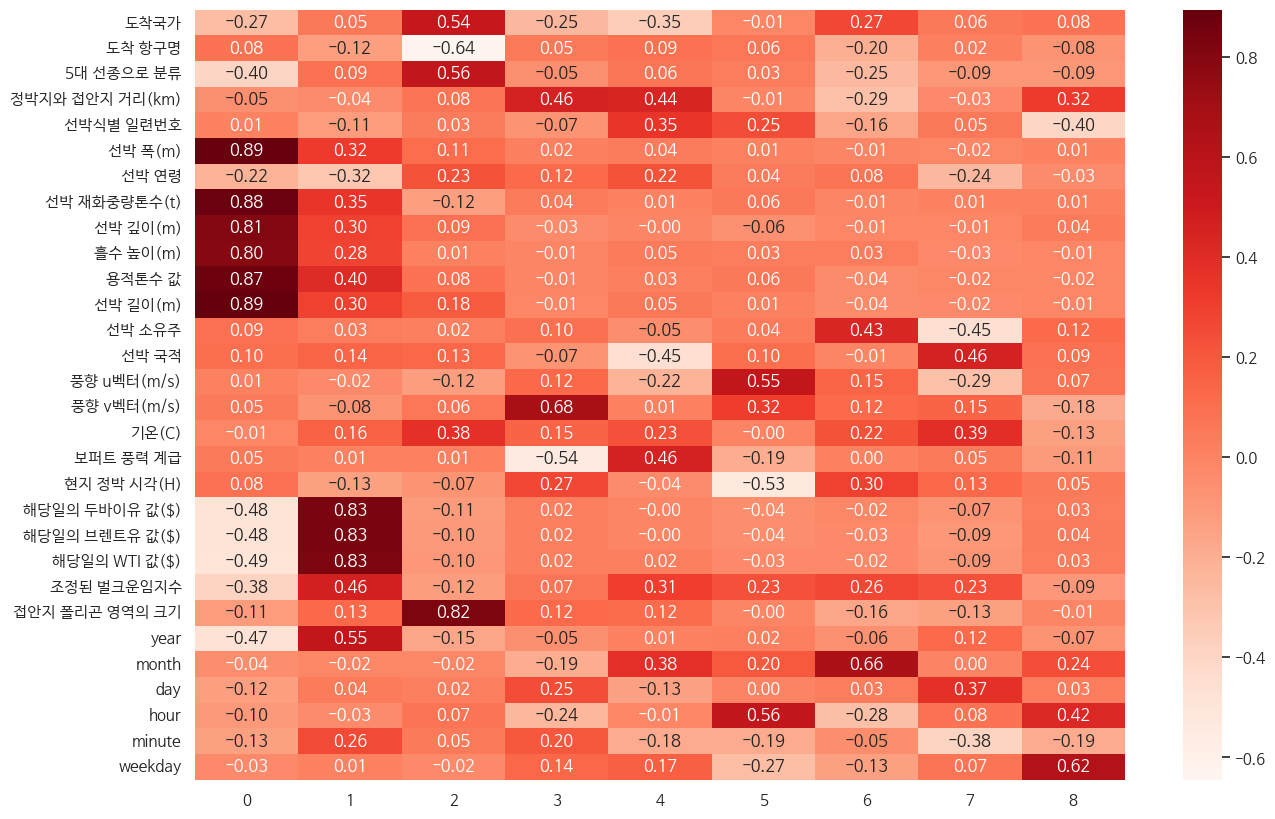

In [277]:
# Heat Map으로 그려서 확인해보겠습니다.
plt.figure(figsize=(15,10))
sns.heatmap(fa_result, cmap="Reds", annot=True, fmt='.2f', )

In [278]:
pd.DataFrame(data=fa.get_factor_variance(), index=['SS Loadings', 'Proportion Var', 'Cumulative Var'], columns=[f'factor{n}' for n in range(fa.n_factors)])

,factor0,factor1,factor2,factor3,factor4,factor5,factor6,factor7,factor8
SS Loadings,5.836737,3.530218,2.085286,1.426103,1.364461,1.332494,1.290591,1.160060,1.057538
Proportion Var,0.194558,0.117674,0.069510,0.047537,0.045482,0.044416,0.043020,0.038669,0.035251
Cumulative Var,0.194558,0.312232,0.381741,0.429278,0.474760,0.519177,0.562196,0.600865,0.636116


In [279]:
fa

FactorAnalyzer(method='principal', n_factors=9, rotation=None,
               rotation_kwargs={})

##### 5) 크론바흐 계수(신뢰도) 계산 : 0.8이상 양호

In [280]:
# 크론바흐 계수를 계산하는 함수를 선언하겠습니다.
def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [281]:
X_copy_y = X_copy.copy() 
X_copy_y['y'] = y

In [282]:
# ET와 ETA 신뢰계수
print(CronbachAlpha(X_copy_y[['해당일의 브렌트유 값($)', 'y']]))

0.0038825664656481074


In [283]:
# # ET와 ETAA 신뢰계수
# print(CronbachAlpha(train[['ET','A_DISTANCE']]))

##### 6) 요인점수를 활용한 변수 생성

In [284]:
X_copy

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),해당일의 두바이유 값($),해당일의 브렌트유 값($),해당일의 WTI 값($),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,year,month,day,hour,minute,weekday
0,4.0,13.0,0.0,30.736578,24336.0,30.0,28.0,73100.0,20.0,10.0,38600.0,220.0,591.0,18.0,0.140000,3.770000,15.900000,2.730798,12.0,42.009998,43.160000,40.959999,1407.668335,0.001660,2020.0,10.0,15.0,4.0,3.0,3.0
1,4.0,14.0,2.0,63.220425,19551.0,30.0,15.0,37900.0,20.0,10.0,28100.0,220.0,723.0,100.0,-3.160000,-6.720000,24.500000,4.289058,10.0,67.529999,64.550003,59.340000,2089.046875,0.001614,2019.0,9.0,17.0,2.0,55.0,1.0
2,4.0,45.0,2.0,90.427422,20448.0,50.0,7.0,115000.0,20.0,10.0,96400.0,300.0,2198.0,65.0,0.000000,0.000000,9.400000,0.000000,14.0,65.300003,66.389999,56.939999,603.193054,0.001743,2019.0,2.0,23.0,6.0,43.0,5.0
3,8.0,75.0,1.0,0.000000,1688.0,10.0,33.0,1490.0,10.0,0.0,700.0,70.0,3225.0,79.0,4.340000,-7.310000,22.100000,4.693735,7.0,43.020000,43.150002,41.110001,1169.853516,0.000069,2020.0,9.0,18.0,22.0,6.0,4.0
4,16.0,46.0,2.0,8.813725,2988.0,30.0,10.0,27600.0,10.0,10.0,19300.0,180.0,3722.0,87.0,1.920000,2.310000,22.799999,2.345875,14.0,90.449997,93.650002,88.110001,1107.944946,0.000197,2022.0,8.0,13.0,12.0,57.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,8.0,101.0,3.0,0.000000,4245.0,10.0,3.0,1180.0,0.0,0.0,500.0,60.0,1047.0,57.0,0.810000,0.320000,1.400000,1.027656,22.0,88.389999,91.209999,88.150002,1177.752075,0.000356,2022.0,1.0,31.0,13.0,37.0,0.0
496,17.0,21.0,2.0,2.276263,23763.0,30.0,15.0,55400.0,20.0,10.0,43100.0,270.0,3376.0,87.0,0.160000,-2.130000,25.600000,1.868946,1.0,80.959999,83.029999,78.199997,1043.115234,0.002615,2022.0,11.0,29.0,17.0,45.0,1.0
497,4.0,62.0,0.0,0.000000,17830.0,30.0,13.0,58100.0,20.0,10.0,32400.0,190.0,5255.0,65.0,-0.297587,-0.262947,18.867313,2.706481,14.0,43.889999,50.540001,47.900002,670.577820,0.000595,2015.0,11.0,3.0,6.0,56.0,1.0
498,19.0,35.0,2.0,0.000000,16131.0,30.0,16.0,22000.0,10.0,10.0,16500.0,170.0,5145.0,65.0,-0.297587,-0.262947,18.867313,2.706481,22.0,45.669998,49.000000,47.959999,1164.740601,0.000990,2016.0,11.0,24.0,14.0,10.0,3.0


In [285]:
fa.transform(X_copy)

array([[ 0.3234381 , -1.0509772 ,  0.36259498, ...,  0.35254348,
         0.33829345, -0.73601422],
       [-0.20368591,  0.39069808,  0.99588935, ..., -0.56496264,
         0.88588737, -1.06023444],
       [ 0.86518273,  0.46533861,  0.44704201, ..., -2.473781  ,
        -0.35248958,  0.91118912],
       ...,
       [ 0.52603701, -0.94743092, -0.57159215, ...,  1.25419395,
        -1.26671635, -0.90751865],
       [-0.24722053, -1.15667032,  0.90224258, ...,  1.70286186,
         0.60596686,  0.79793914],
       [-0.54176397,  1.47920061,  1.82793556, ...,  1.49640634,
         0.50549485,  0.02397308]])